In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
import splitfolders # or import splitfolders
input_folder = "Data/Augmented Images"
output = "withaug" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .2, .1)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 3192 files [01:04, 49.37 files/s]


In [4]:
train_path = "withaug/train"
test_path = "withaug/test"


In [5]:
IMAGE_SIZE = [128,128]

In [6]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 2233 images belonging to 2 classes.
Found 959 images belonging to 2 classes.


In [8]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [10]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# ResNet50

In [11]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
x = Flatten()(resnet.output)

In [12]:
prediction = Dense(2, activation='softmax')(x)
model1 = Model(inputs = resnet.inputs, outputs = prediction)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

In [ ]:
hist1 = model1.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/200
1117/1117 [==============================] - 1212s 1s/step - loss: 1.5607 - accuracy: 0.5338 - f1_m: 0.5336 - precision_m: 0.5336 - recall_m: 0.5336 - val_loss: 0.7003 - val_accuracy: 0.4473 - val_f1_m: 0.4469 - val_precision_m: 0.4469 - val_recall_m: 0.4469
Epoch 2/200
1117/1117 [==============================] - 1000s 895ms/step - loss: 0.7352 - accuracy: 0.5208 - f1_m: 0.5206 - precision_m: 0.5206 - recall_m: 0.5206 - val_loss: 0.7670 - val_accuracy: 0.4473 - val_f1_m: 0.4479 - val_precision_m: 0.4479 - val_recall_m: 0.4479
Epoch 3/200
1117/1117 [==============================] - 840s 752ms/step - loss: 0.7113 - accuracy: 0.5316 - f1_m: 0.5318 - precision_m: 0.5318 - recall_m: 0.5318 - val_loss: 0.7057 - val_accuracy: 0.4473 - val_f1_m: 0.4479 - val_precision_m: 0.4479 - val_recall_m: 0.4479
Epoch 4/200
1117/1117 [==============================] - 673s 603ms/step - loss: 0.7201 - accuracy: 0.5562 - f1_m: 0.5564 - precision_m: 0.5564 - recall_m: 0.5564 - val_loss: 0.6819 

In [15]:
res50_acc = hist1.history["val_accuracy"][25]
res50_prec = hist1.history["val_precision_m"][25]
res50_rec = hist1.history["val_recall_m"][25]
res50_f1 = hist1.history["val_f1_m"][25]

NameError: name 'hist1' is not defined

In [30]:
storeResults('ResNet50',res50_acc,res50_prec,res50_rec,res50_f1)

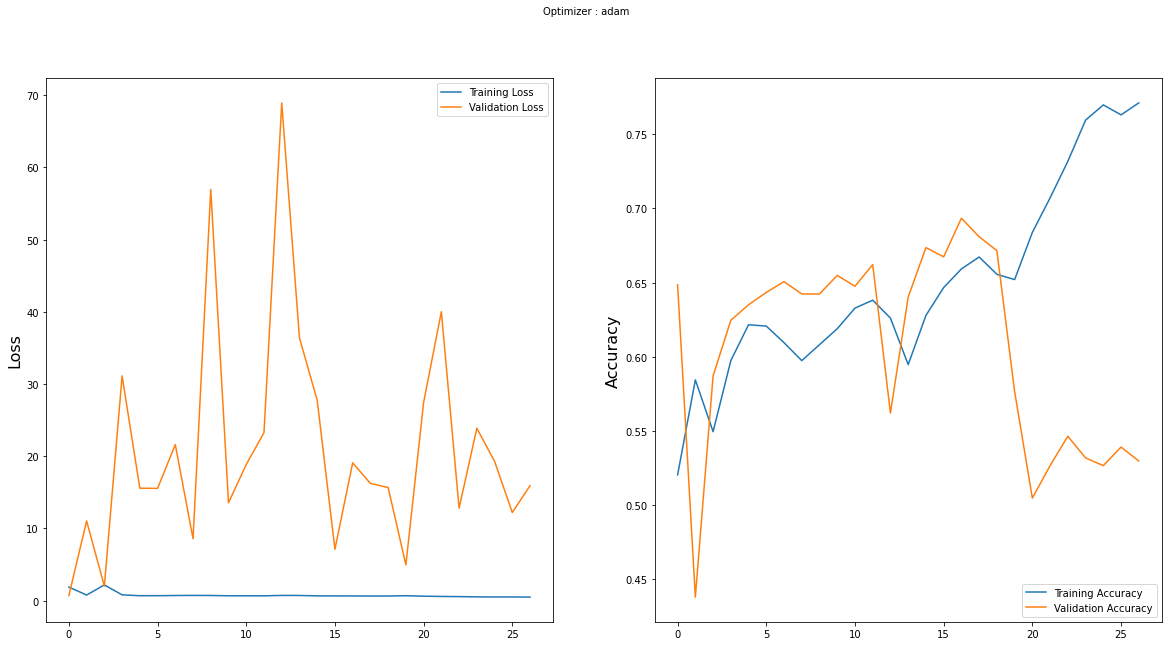

In [15]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# VGG16

In [16]:
vgg16=VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [17]:
x1= Flatten()(vgg16.output)
prediction1 = Dense(2, activation='softmax')(x1)
model2 = Model(inputs = vgg16.inputs, outputs = prediction1)
model2.summary()
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [18]:
hist2 = model2.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/200
1117/1117 [==============================] - 36s 30ms/step - loss: 0.9932 - accuracy: 0.5387 - f1_m: 0.5389 - precision_m: 0.5389 - recall_m: 0.5389 - val_loss: 0.6887 - val_accuracy: 0.5527 - val_f1_m: 0.5531 - val_precision_m: 0.5531 - val_recall_m: 0.5531
Epoch 2/200
1117/1117 [==============================] - 33s 29ms/step - loss: 0.6883 - accuracy: 0.5526 - f1_m: 0.5528 - precision_m: 0.5528 - recall_m: 0.5528 - val_loss: 0.6877 - val_accuracy: 0.5527 - val_f1_m: 0.5531 - val_precision_m: 0.5531 - val_recall_m: 0.5531
Epoch 3/200
1117/1117 [==============================] - 33s 29ms/step - loss: 0.6879 - accuracy: 0.5526 - f1_m: 0.5528 - precision_m: 0.5528 - recall_m: 0.5528 - val_loss: 0.6876 - val_accuracy: 0.5527 - val_f1_m: 0.5531 - val_precision_m: 0.5531 - val_recall_m: 0.5531
Epoch 4/200
1117/1117 [==============================] - 32s 29ms/step - loss: 0.6878 - accuracy: 0.5526 - f1_m: 0.5524 - precision_m: 0.5524 - recall_m: 0.5524 - val_loss: 0.6876 - val_a

In [23]:
vgg_acc = hist2.history["val_accuracy"][25]
vgg_prec = hist2.history["val_precision_m"][25]
vgg_rec = hist2.history["val_recall_m"][25]
vgg_f1 = hist2.history["val_f1_m"][25]

In [31]:
storeResults('VGG16',vgg_acc,vgg_prec,vgg_rec,vgg_f1)

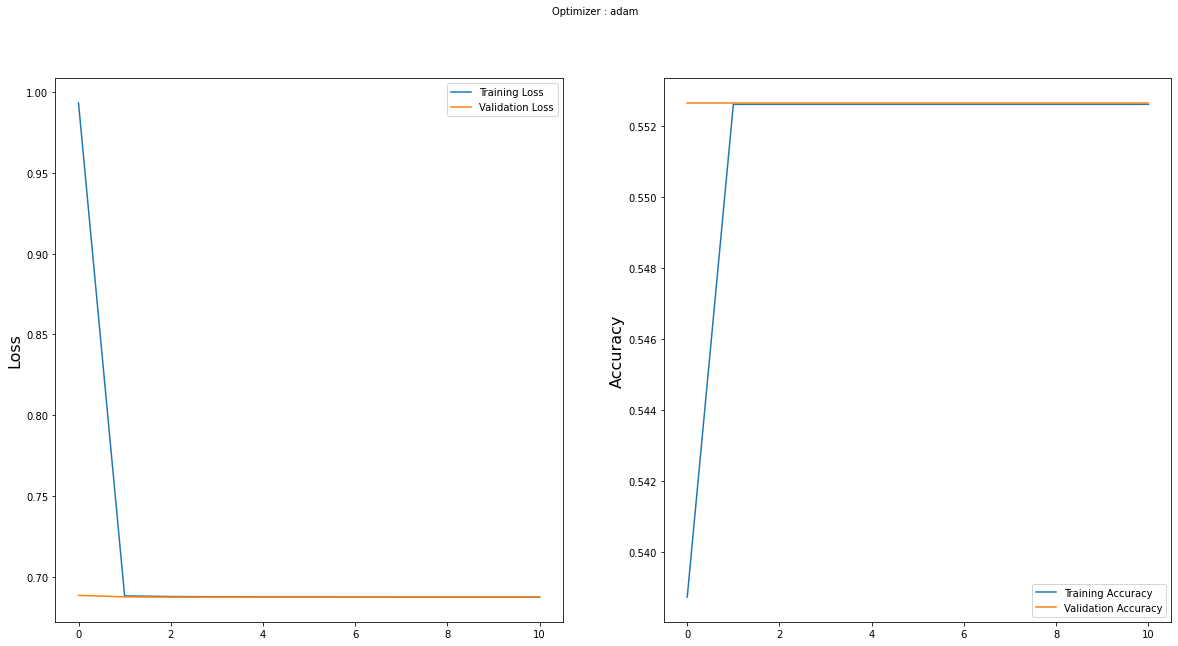

In [19]:
import matplotlib.pyplot as plt

x=hist2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Inception ResNetV2

In [20]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [21]:
mob1 = InceptionResNetV2(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [22]:
x1= Flatten()(mob1.output)
prediction1 = Dense(2, activation='softmax')(x1)
model3 = Model(inputs = mob1.inputs, outputs = prediction1)
model3.summary()
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [23]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/200
1117/1117 [==============================] - 340s 292ms/step - loss: 1.0863 - accuracy: 0.5701 - f1_m: 0.5703 - precision_m: 0.5703 - recall_m: 0.5703 - val_loss: 606.4689 - val_accuracy: 0.5631 - val_f1_m: 0.5625 - val_precision_m: 0.5625 - val_recall_m: 0.5625
Epoch 2/200
1117/1117 [==============================] - 330s 296ms/step - loss: 1.2345 - accuracy: 0.5226 - f1_m: 0.5224 - precision_m: 0.5224 - recall_m: 0.5224 - val_loss: 1005.5301 - val_accuracy: 0.4473 - val_f1_m: 0.4469 - val_precision_m: 0.4469 - val_recall_m: 0.4469
Epoch 3/200
1117/1117 [==============================] - 329s 295ms/step - loss: 0.9556 - accuracy: 0.5096 - f1_m: 0.5094 - precision_m: 0.5094 - recall_m: 0.5094 - val_loss: 2.7272 - val_accuracy: 0.5287 - val_f1_m: 0.5281 - val_precision_m: 0.5281 - val_recall_m: 0.5281
Epoch 4/200
1117/1117 [==============================] - 326s 292ms/step - loss: 0.8523 - accuracy: 0.5423 - f1_m: 0.5421 - precision_m: 0.5421 - recall_m: 0.5421 - val_loss: 0

Epoch 30/200
1117/1117 [==============================] - 329s 295ms/step - loss: 0.2686 - accuracy: 0.8925 - f1_m: 0.8926 - precision_m: 0.8926 - recall_m: 0.8926 - val_loss: 19.6676 - val_accuracy: 0.7612 - val_f1_m: 0.7615 - val_precision_m: 0.7615 - val_recall_m: 0.7615
Epoch 31/200
1117/1117 [==============================] - 328s 294ms/step - loss: 0.2646 - accuracy: 0.8997 - f1_m: 0.8993 - precision_m: 0.8993 - recall_m: 0.8993 - val_loss: 10.9767 - val_accuracy: 0.7716 - val_f1_m: 0.7719 - val_precision_m: 0.7719 - val_recall_m: 0.7719
Epoch 32/200
1117/1117 [==============================] - 324s 290ms/step - loss: 0.2420 - accuracy: 0.8961 - f1_m: 0.8962 - precision_m: 0.8962 - recall_m: 0.8962 - val_loss: 22.4725 - val_accuracy: 0.7758 - val_f1_m: 0.7760 - val_precision_m: 0.7760 - val_recall_m: 0.7760
Epoch 33/200
1117/1117 [==============================] - 328s 293ms/step - loss: 0.2316 - accuracy: 0.9042 - f1_m: 0.9042 - precision_m: 0.9042 - recall_m: 0.9042 - val_loss:

In [24]:
incres_acc = hist3.history["val_accuracy"][25]
incres_prec = hist3.history["val_precision_m"][25]
incres_rec = hist3.history["val_recall_m"][25]
incres_f1 = hist3.history["val_f1_m"][25]

In [32]:
storeResults('Inception ResNetV2',incres_acc,incres_prec,incres_rec,incres_f1)

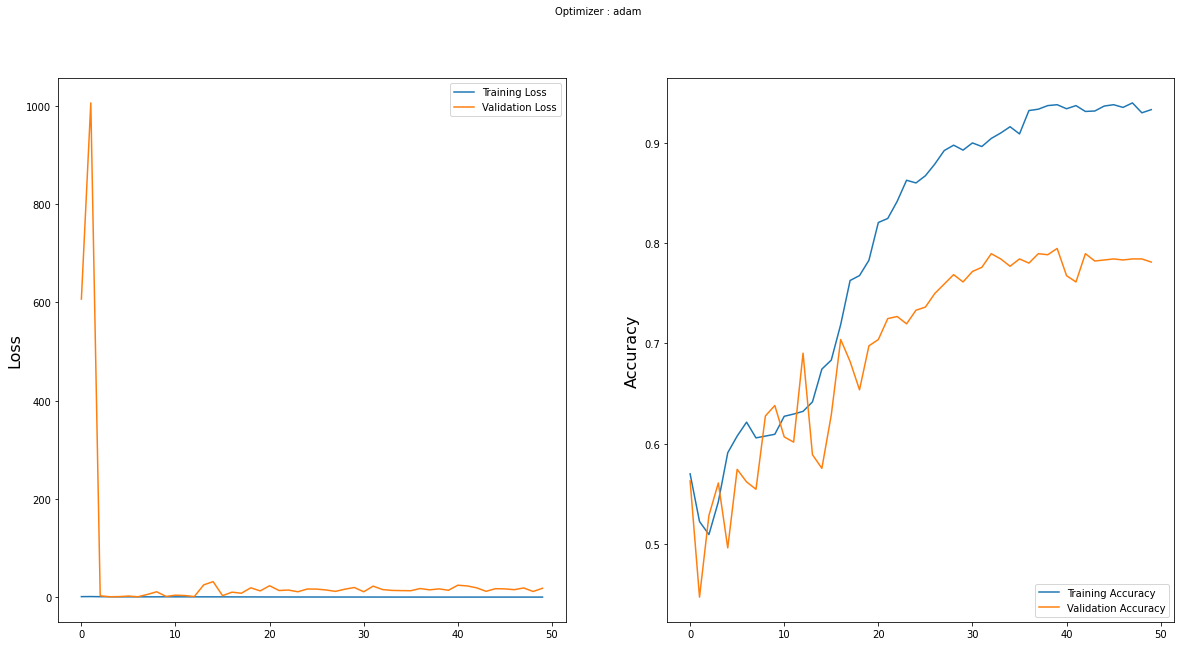

In [24]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet201

In [25]:
from tensorflow.keras.applications import DenseNet201

In [26]:
des201=DenseNet201(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [27]:
x1= Flatten()(des201.output)
prediction1 = Dense(2, activation='softmax')(x1)
model4 = Model(inputs = des201.inputs, outputs = prediction1)
model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [29]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/200
1117/1117 [==============================] - 233s 209ms/step - loss: 0.0460 - accuracy: 0.9852 - f1_m: 0.9852 - precision_m: 0.9852 - recall_m: 0.9852 - val_loss: 0.3410 - val_accuracy: 0.9051 - val_f1_m: 0.9052 - val_precision_m: 0.9052 - val_recall_m: 0.9052
Epoch 2/200
1117/1117 [==============================] - 228s 204ms/step - loss: 0.0567 - accuracy: 0.9776 - f1_m: 0.9776 - precision_m: 0.9776 - recall_m: 0.9776 - val_loss: 0.3422 - val_accuracy: 0.9072 - val_f1_m: 0.9073 - val_precision_m: 0.9073 - val_recall_m: 0.9073
Epoch 3/200
1117/1117 [==============================] - 225s 201ms/step - loss: 0.0408 - accuracy: 0.9848 - f1_m: 0.9848 - precision_m: 0.9848 - recall_m: 0.9848 - val_loss: 0.4010 - val_accuracy: 0.8978 - val_f1_m: 0.8979 - val_precision_m: 0.8979 - val_recall_m: 0.8979
Epoch 4/200
1117/1117 [==============================] - 231s 207ms/step - loss: 0.0484 - accuracy: 0.9812 - f1_m: 0.9812 - precision_m: 0.9812 - recall_m: 0.9812 - val_loss: 0.4885

1117/1117 [==============================] - 233s 208ms/step - loss: 0.0277 - accuracy: 0.9910 - f1_m: 0.9910 - precision_m: 0.9910 - recall_m: 0.9910 - val_loss: 0.8548 - val_accuracy: 0.8947 - val_f1_m: 0.8948 - val_precision_m: 0.8948 - val_recall_m: 0.8948
Epoch 60/200
1117/1117 [==============================] - 221s 198ms/step - loss: 0.0261 - accuracy: 0.9879 - f1_m: 0.9879 - precision_m: 0.9879 - recall_m: 0.9879 - val_loss: 2.4989 - val_accuracy: 0.8624 - val_f1_m: 0.8625 - val_precision_m: 0.8625 - val_recall_m: 0.8625
Epoch 61/200
1117/1117 [==============================] - 234s 209ms/step - loss: 0.0283 - accuracy: 0.9897 - f1_m: 0.9897 - precision_m: 0.9897 - recall_m: 0.9897 - val_loss: 0.4015 - val_accuracy: 0.9114 - val_f1_m: 0.9115 - val_precision_m: 0.9115 - val_recall_m: 0.9115
Epoch 62/200
1117/1117 [==============================] - 226s 202ms/step - loss: 0.0184 - accuracy: 0.9933 - f1_m: 0.9933 - precision_m: 0.9933 - recall_m: 0.9933 - val_loss: 0.4767 - val_ac

1117/1117 [==============================] - 229s 205ms/step - loss: 0.0104 - accuracy: 0.9951 - f1_m: 0.9951 - precision_m: 0.9951 - recall_m: 0.9951 - val_loss: 0.5969 - val_accuracy: 0.9176 - val_f1_m: 0.9177 - val_precision_m: 0.9177 - val_recall_m: 0.9177
Epoch 118/200
1117/1117 [==============================] - 221s 198ms/step - loss: 0.0148 - accuracy: 0.9946 - f1_m: 0.9946 - precision_m: 0.9946 - recall_m: 0.9946 - val_loss: 0.4367 - val_accuracy: 0.9249 - val_f1_m: 0.9250 - val_precision_m: 0.9250 - val_recall_m: 0.9250
Epoch 119/200
1117/1117 [==============================] - 232s 208ms/step - loss: 0.0152 - accuracy: 0.9951 - f1_m: 0.9951 - precision_m: 0.9951 - recall_m: 0.9951 - val_loss: 0.6348 - val_accuracy: 0.9041 - val_f1_m: 0.9042 - val_precision_m: 0.9042 - val_recall_m: 0.9042
Epoch 120/200
1117/1117 [==============================] - 221s 198ms/step - loss: 0.0275 - accuracy: 0.9919 - f1_m: 0.9919 - precision_m: 0.9919 - recall_m: 0.9919 - val_loss: 0.5268 - val

1117/1117 [==============================] - 220s 197ms/step - loss: 0.0068 - accuracy: 0.9982 - f1_m: 0.9982 - precision_m: 0.9982 - recall_m: 0.9982 - val_loss: 0.5164 - val_accuracy: 0.9291 - val_f1_m: 0.9292 - val_precision_m: 0.9292 - val_recall_m: 0.9292
Epoch 176/200
1117/1117 [==============================] - 228s 204ms/step - loss: 0.0169 - accuracy: 0.9951 - f1_m: 0.9951 - precision_m: 0.9951 - recall_m: 0.9951 - val_loss: 0.5813 - val_accuracy: 0.9135 - val_f1_m: 0.9135 - val_precision_m: 0.9135 - val_recall_m: 0.9135
Epoch 177/200
1117/1117 [==============================] - 229s 205ms/step - loss: 0.0102 - accuracy: 0.9973 - f1_m: 0.9973 - precision_m: 0.9973 - recall_m: 0.9973 - val_loss: 0.6229 - val_accuracy: 0.9072 - val_f1_m: 0.9073 - val_precision_m: 0.9073 - val_recall_m: 0.9073
Epoch 178/200
1117/1117 [==============================] - 221s 198ms/step - loss: 0.0062 - accuracy: 0.9973 - f1_m: 0.9973 - precision_m: 0.9973 - recall_m: 0.9973 - val_loss: 0.5917 - val

In [25]:
den_acc = hist4.history["val_accuracy"][199]
den_prec = hist4.history["val_precision_m"][199]
den_rec = hist4.history["val_recall_m"][199]
den_f1 = hist4.history["val_f1_m"][199]

In [33]:
storeResults('DenseNet201',den_acc,den_prec,den_rec,den_f1)

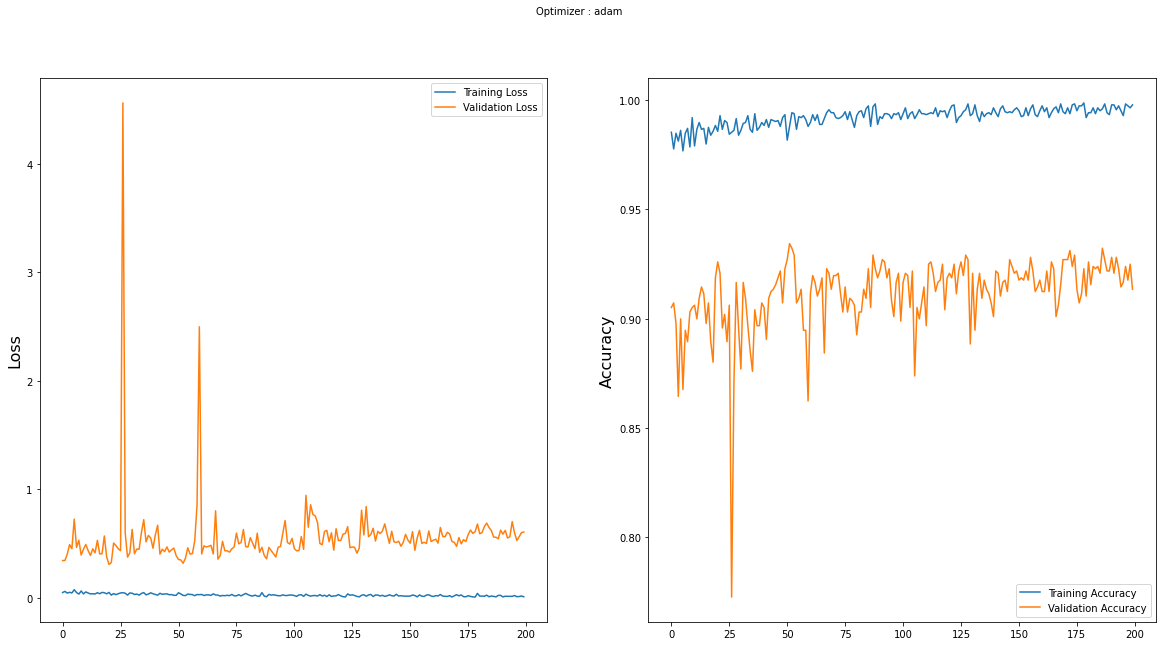

In [30]:
import matplotlib.pyplot as plt

x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# InceptionV3

In [31]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = InceptionV3(input_shape = IMAGE_SIZE + [3],weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x2 = base_model.output
x2 = GlobalAveragePooling2D()(x2)

In [32]:
predictions = Dense(2, activation='softmax')(x2)

# this is the model we will train
model5 = Model(inputs=base_model.input, outputs=predictions)
model5.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 63, 63, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 63, 63, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 63, 63, 32)   0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

In [33]:
hist5 = model5.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/200
1117/1117 [==============================] - 91s 76ms/step - loss: 0.8917 - accuracy: 0.5007 - f1_m: 0.5009 - precision_m: 0.5009 - recall_m: 0.5009 - val_loss: 2.6692 - val_accuracy: 0.4640 - val_f1_m: 0.4646 - val_precision_m: 0.4646 - val_recall_m: 0.4646
Epoch 2/200
1117/1117 [==============================] - 83s 74ms/step - loss: 0.7879 - accuracy: 0.5096 - f1_m: 0.5098 - precision_m: 0.5098 - recall_m: 0.5098 - val_loss: 20204.1504 - val_accuracy: 0.5819 - val_f1_m: 0.5823 - val_precision_m: 0.5823 - val_recall_m: 0.5823
Epoch 3/200
1117/1117 [==============================] - 82s 73ms/step - loss: 0.7575 - accuracy: 0.5383 - f1_m: 0.5385 - precision_m: 0.5385 - recall_m: 0.5385 - val_loss: 355.0249 - val_accuracy: 0.5360 - val_f1_m: 0.5365 - val_precision_m: 0.5365 - val_recall_m: 0.5365
Epoch 4/200
1117/1117 [==============================] - 83s 74ms/step - loss: 0.7332 - accuracy: 0.5226 - f1_m: 0.5224 - precision_m: 0.5224 - recall_m: 0.5224 - val_loss: 2603.795

1117/1117 [==============================] - 82s 74ms/step - loss: 0.6854 - accuracy: 0.5405 - f1_m: 0.5407 - precision_m: 0.5407 - recall_m: 0.5407 - val_loss: 6.6061 - val_accuracy: 0.5547 - val_f1_m: 0.5552 - val_precision_m: 0.5552 - val_recall_m: 0.5552
Epoch 60/200
1117/1117 [==============================] - 82s 74ms/step - loss: 0.6879 - accuracy: 0.5414 - f1_m: 0.5412 - precision_m: 0.5412 - recall_m: 0.5412 - val_loss: 16.5452 - val_accuracy: 0.5464 - val_f1_m: 0.5469 - val_precision_m: 0.5469 - val_recall_m: 0.5469
Epoch 61/200
1117/1117 [==============================] - 82s 74ms/step - loss: 0.6843 - accuracy: 0.5455 - f1_m: 0.5452 - precision_m: 0.5452 - recall_m: 0.5452 - val_loss: 11.6730 - val_accuracy: 0.5193 - val_f1_m: 0.5188 - val_precision_m: 0.5188 - val_recall_m: 0.5188
Epoch 62/200
1117/1117 [==============================] - 83s 75ms/step - loss: 0.6820 - accuracy: 0.5396 - f1_m: 0.5398 - precision_m: 0.5398 - recall_m: 0.5398 - val_loss: 11.8371 - val_accurac

Epoch 119/200
1117/1117 [==============================] - 83s 74ms/step - loss: 0.6450 - accuracy: 0.6341 - f1_m: 0.6343 - precision_m: 0.6343 - recall_m: 0.6343 - val_loss: 4.2278 - val_accuracy: 0.6361 - val_f1_m: 0.6354 - val_precision_m: 0.6354 - val_recall_m: 0.6354
Epoch 120/200
1117/1117 [==============================] - 82s 74ms/step - loss: 0.6439 - accuracy: 0.6355 - f1_m: 0.6356 - precision_m: 0.6356 - recall_m: 0.6356 - val_loss: 57.5234 - val_accuracy: 0.5683 - val_f1_m: 0.5688 - val_precision_m: 0.5688 - val_recall_m: 0.5688
Epoch 121/200
1117/1117 [==============================] - 82s 74ms/step - loss: 0.6486 - accuracy: 0.6314 - f1_m: 0.6312 - precision_m: 0.6312 - recall_m: 0.6312 - val_loss: 44.8007 - val_accuracy: 0.5704 - val_f1_m: 0.5708 - val_precision_m: 0.5708 - val_recall_m: 0.5708
Epoch 122/200
1117/1117 [==============================] - 82s 74ms/step - loss: 0.6427 - accuracy: 0.6408 - f1_m: 0.6406 - precision_m: 0.6406 - recall_m: 0.6406 - val_loss: 94.2

1117/1117 [==============================] - 83s 74ms/step - loss: 0.5196 - accuracy: 0.7362 - f1_m: 0.7363 - precision_m: 0.7363 - recall_m: 0.7363 - val_loss: 2.7355 - val_accuracy: 0.6548 - val_f1_m: 0.6542 - val_precision_m: 0.6542 - val_recall_m: 0.6542
Epoch 178/200
1117/1117 [==============================] - 83s 74ms/step - loss: 0.4942 - accuracy: 0.7546 - f1_m: 0.7547 - precision_m: 0.7547 - recall_m: 0.7547 - val_loss: 3.6009 - val_accuracy: 0.6298 - val_f1_m: 0.6302 - val_precision_m: 0.6302 - val_recall_m: 0.6302
Epoch 179/200
1117/1117 [==============================] - 83s 74ms/step - loss: 0.4997 - accuracy: 0.7461 - f1_m: 0.7457 - precision_m: 0.7457 - recall_m: 0.7457 - val_loss: 3.4517 - val_accuracy: 0.6027 - val_f1_m: 0.6031 - val_precision_m: 0.6031 - val_recall_m: 0.6031
Epoch 180/200
1117/1117 [==============================] - 81s 72ms/step - loss: 0.4961 - accuracy: 0.7443 - f1_m: 0.7444 - precision_m: 0.7444 - recall_m: 0.7444 - val_loss: 2.7378 - val_accurac

In [26]:
inc_acc = hist5.history["val_accuracy"][199]
inc_prec = hist5.history["val_precision_m"][199]
inc_rec = hist5.history["val_recall_m"][199]
inc_f1 = hist5.history["val_f1_m"][199]

In [34]:
storeResults('InceptionV3',inc_acc,inc_prec,inc_rec,inc_f1)

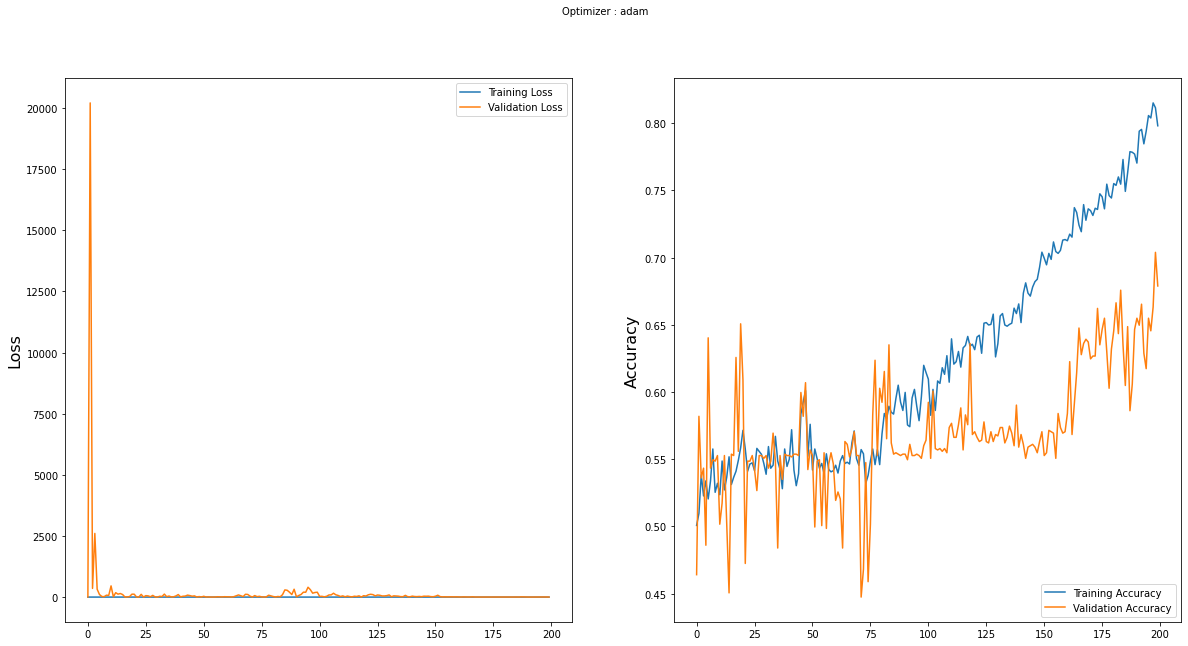

In [34]:
import matplotlib.pyplot as plt

x=hist5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# EfficientNetB7

In [17]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
eff = EfficientNetB7(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [18]:
x1= Flatten()(eff.output)
prediction1 = Dense(2, activation='softmax')(x1)
model6 = Model(inputs = eff.inputs, outputs = prediction1)
model6.summary()
model6.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [19]:
hist6 = model6.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/200
1117/1117 [==============================] - 1155s 997ms/step - loss: 1.4571 - accuracy: 0.5172 - f1_m: 0.5175 - precision_m: 0.5175 - recall_m: 0.5175 - val_loss: 0.8811 - val_accuracy: 0.5527 - val_f1_m: 0.5531 - val_precision_m: 0.5531 - val_recall_m: 0.5531
Epoch 2/200
1117/1117 [==============================] - 1375s 1s/step - loss: 0.8692 - accuracy: 0.5226 - f1_m: 0.5228 - precision_m: 0.5228 - recall_m: 0.5228 - val_loss: 0.6960 - val_accuracy: 0.6517 - val_f1_m: 0.6510 - val_precision_m: 0.6510 - val_recall_m: 0.6510
Epoch 3/200
1117/1117 [==============================] - 1357s 1s/step - loss: 0.8022 - accuracy: 0.5880 - f1_m: 0.5882 - precision_m: 0.5882 - recall_m: 0.5882 - val_loss: 0.7375 - val_accuracy: 0.5652 - val_f1_m: 0.5656 - val_precision_m: 0.5656 - val_recall_m: 0.5656
Epoch 4/200
1117/1117 [==============================] - 1106s 990ms/step - loss: 0.7501 - accuracy: 0.6301 - f1_m: 0.6303 - precision_m: 0.6303 - recall_m: 0.6303 - val_loss: 0.6716 -

Epoch 29/200
1117/1117 [==============================] - 1392s 1s/step - loss: 0.6762 - accuracy: 0.5849 - f1_m: 0.5850 - precision_m: 0.5850 - recall_m: 0.5850 - val_loss: 0.6457 - val_accuracy: 0.6559 - val_f1_m: 0.6562 - val_precision_m: 0.6562 - val_recall_m: 0.6562
Epoch 30/200
1117/1117 [==============================] - 1183s 1s/step - loss: 0.6736 - accuracy: 0.5952 - f1_m: 0.5953 - precision_m: 0.5953 - recall_m: 0.5953 - val_loss: 0.6581 - val_accuracy: 0.6330 - val_f1_m: 0.6333 - val_precision_m: 0.6333 - val_recall_m: 0.6333

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 31/200
1117/1117 [==============================] - 1302s 1s/step - loss: 0.6777 - accuracy: 0.5799 - f1_m: 0.5797 - precision_m: 0.5797 - recall_m: 0.5797 - val_loss: 0.6494 - val_accuracy: 0.6486 - val_f1_m: 0.6490 - val_precision_m: 0.6490 - val_recall_m: 0.6490
Epoch 32/200
1117/1117 [==============================] - 1389s 1s/step - loss: 0.6707 - accuracy: 0.5929 - f1_m: 0.592

In [27]:
eff_acc = hist6.history["val_accuracy"][36]
eff_prec = hist6.history["val_precision_m"][36]
eff_rec = hist6.history["val_recall_m"][36]
eff_f1 = hist6.history["val_f1_m"][36]

In [35]:
storeResults('EfficientNetB7',eff_acc,eff_prec,eff_rec,eff_f1)

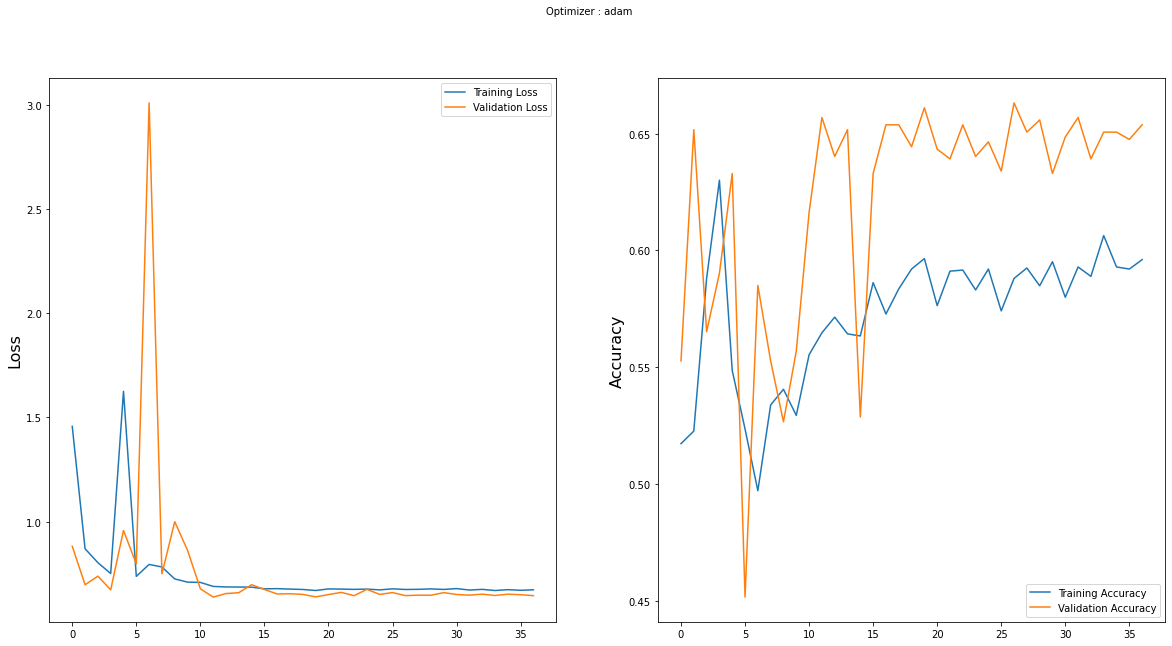

In [20]:
import matplotlib.pyplot as plt

x=hist6
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# POXNET22 with InceptionV3

In [10]:
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [11]:
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape = IMAGE_SIZE + [3])

In [12]:
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(2, 
                    activation='softmax'))

In [13]:
from tensorflow.keras import optimizers, losses, activations, models

In [14]:
model7 = add_model
model7.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy',f1_m,precision_m, recall_m])
model7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
hist7 = model7.fit(train_set, validation_data=train_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(train_set))

Epoch 1/200
1117/1117 [==============================] - 164s 129ms/step - loss: 1.1531 - accuracy: 0.6852 - f1_m: 0.6849 - precision_m: 0.6849 - recall_m: 0.6849 - val_loss: 1.0211 - val_accuracy: 0.7344 - val_f1_m: 0.7346 - val_precision_m: 0.7346 - val_recall_m: 0.7346
Epoch 2/200
1117/1117 [==============================] - 140s 126ms/step - loss: 1.0134 - accuracy: 0.7470 - f1_m: 0.7471 - precision_m: 0.7471 - recall_m: 0.7471 - val_loss: 0.9707 - val_accuracy: 0.6991 - val_f1_m: 0.6987 - val_precision_m: 0.6987 - val_recall_m: 0.6987
Epoch 3/200
1117/1117 [==============================] - 136s 121ms/step - loss: 0.8934 - accuracy: 0.7550 - f1_m: 0.7551 - precision_m: 0.7551 - recall_m: 0.7551 - val_loss: 0.4800 - val_accuracy: 0.8365 - val_f1_m: 0.8366 - val_precision_m: 0.8366 - val_recall_m: 0.8366
Epoch 4/200
1117/1117 [==============================] - 136s 122ms/step - loss: 0.8694 - accuracy: 0.7761 - f1_m: 0.7762 - precision_m: 0.7762 - recall_m: 0.7762 - val_loss: 0.5951

Epoch 31/200
1117/1117 [==============================] - 136s 122ms/step - loss: 0.9315 - accuracy: 0.7855 - f1_m: 0.7856 - precision_m: 0.7856 - recall_m: 0.7856 - val_loss: 0.3826 - val_accuracy: 0.8737 - val_f1_m: 0.8738 - val_precision_m: 0.8738 - val_recall_m: 0.8738
Epoch 32/200
1117/1117 [==============================] - 138s 123ms/step - loss: 0.8326 - accuracy: 0.8061 - f1_m: 0.8057 - precision_m: 0.8057 - recall_m: 0.8057 - val_loss: 0.5209 - val_accuracy: 0.8383 - val_f1_m: 0.8384 - val_precision_m: 0.8384 - val_recall_m: 0.8384
Epoch 33/200
1117/1117 [==============================] - 137s 122ms/step - loss: 0.9270 - accuracy: 0.7761 - f1_m: 0.7762 - precision_m: 0.7762 - recall_m: 0.7762 - val_loss: 0.5578 - val_accuracy: 0.8253 - val_f1_m: 0.8250 - val_precision_m: 0.8250 - val_recall_m: 0.8250
Epoch 34/200
1117/1117 [==============================] - 139s 124ms/step - loss: 0.8861 - accuracy: 0.7936 - f1_m: 0.7936 - precision_m: 0.7936 - recall_m: 0.7936 - val_loss: 0.

Epoch 61/200
1117/1117 [==============================] - 137s 123ms/step - loss: 0.8567 - accuracy: 0.8003 - f1_m: 0.8004 - precision_m: 0.8004 - recall_m: 0.8004 - val_loss: 0.5994 - val_accuracy: 0.8410 - val_f1_m: 0.8406 - val_precision_m: 0.8406 - val_recall_m: 0.8406
Epoch 62/200
1117/1117 [==============================] - 138s 124ms/step - loss: 0.8960 - accuracy: 0.7891 - f1_m: 0.7892 - precision_m: 0.7892 - recall_m: 0.7892 - val_loss: 0.4194 - val_accuracy: 0.8710 - val_f1_m: 0.8711 - val_precision_m: 0.8711 - val_recall_m: 0.8711
Epoch 63/200
1117/1117 [==============================] - 138s 123ms/step - loss: 0.9029 - accuracy: 0.7819 - f1_m: 0.7820 - precision_m: 0.7820 - recall_m: 0.7820 - val_loss: 0.3932 - val_accuracy: 0.8724 - val_f1_m: 0.8724 - val_precision_m: 0.8724 - val_recall_m: 0.8724
Epoch 64/200
1117/1117 [==============================] - 139s 124ms/step - loss: 0.9070 - accuracy: 0.8021 - f1_m: 0.8021 - precision_m: 0.8021 - recall_m: 0.8021 - val_loss: 0.

1117/1117 [==============================] - 166s 149ms/step - loss: 0.8683 - accuracy: 0.7958 - f1_m: 0.7954 - precision_m: 0.7954 - recall_m: 0.7954 - val_loss: 0.5606 - val_accuracy: 0.8585 - val_f1_m: 0.8585 - val_precision_m: 0.8585 - val_recall_m: 0.8585
Epoch 120/200
1117/1117 [==============================] - 165s 147ms/step - loss: 0.9333 - accuracy: 0.7886 - f1_m: 0.7887 - precision_m: 0.7887 - recall_m: 0.7887 - val_loss: 0.3837 - val_accuracy: 0.8863 - val_f1_m: 0.8863 - val_precision_m: 0.8863 - val_recall_m: 0.8863
Epoch 121/200
1117/1117 [==============================] - 59s 53ms/step - loss: 0.9017 - accuracy: 0.7850 - f1_m: 0.7851 - precision_m: 0.7851 - recall_m: 0.7851 - val_loss: 0.6599 - val_accuracy: 0.8155 - val_f1_m: 0.8156 - val_precision_m: 0.8156 - val_recall_m: 0.8156
Epoch 122/200
1117/1117 [==============================] - 52s 46ms/step - loss: 0.8577 - accuracy: 0.7958 - f1_m: 0.7959 - precision_m: 0.7959 - recall_m: 0.7959 - val_loss: 0.4395 - val_acc

Epoch 178/200
1117/1117 [==============================] - 167s 150ms/step - loss: 0.9378 - accuracy: 0.7922 - f1_m: 0.7923 - precision_m: 0.7923 - recall_m: 0.7923 - val_loss: 0.3581 - val_accuracy: 0.8822 - val_f1_m: 0.8823 - val_precision_m: 0.8823 - val_recall_m: 0.8823
Epoch 179/200
1117/1117 [==============================] - 165s 148ms/step - loss: 0.9249 - accuracy: 0.7927 - f1_m: 0.7927 - precision_m: 0.7927 - recall_m: 0.7927 - val_loss: 0.4742 - val_accuracy: 0.8715 - val_f1_m: 0.8715 - val_precision_m: 0.8715 - val_recall_m: 0.8715
Epoch 180/200
1117/1117 [==============================] - 163s 146ms/step - loss: 0.9547 - accuracy: 0.7855 - f1_m: 0.7856 - precision_m: 0.7856 - recall_m: 0.7856 - val_loss: 0.4498 - val_accuracy: 0.8688 - val_f1_m: 0.8688 - val_precision_m: 0.8688 - val_recall_m: 0.8688
Epoch 181/200
1117/1117 [==============================] - 162s 145ms/step - loss: 0.8825 - accuracy: 0.7967 - f1_m: 0.7968 - precision_m: 0.7968 - recall_m: 0.7968 - val_loss

In [28]:
poxnet_acc = hist7.history["val_accuracy"][199]
poxnet_prec = hist7.history["val_precision_m"][199]
poxnet_rec = hist7.history["val_recall_m"][199]
poxnet_f1 = hist7.history["val_f1_m"][199]

In [36]:
storeResults('PoxNet22-InceptionV3',poxnet_acc,poxnet_prec,poxnet_rec,poxnet_f1)

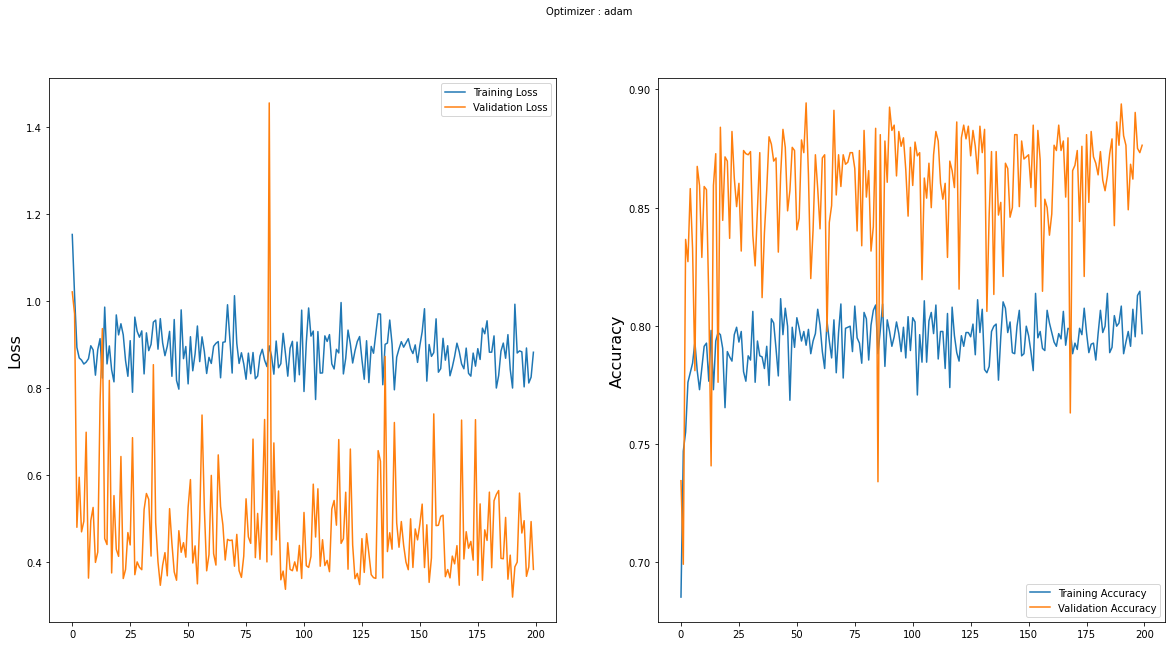

In [16]:
import matplotlib.pyplot as plt

x=hist7
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [39]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score,
                        
                        
                      })

In [40]:
result

,ML Model,Accuracy,Precision,Recall,F1_score
0,ResNet50,0.530,0.592,0.529,0.529
1,VGG16,0.553,0.552,0.552,0.552
2,Inception ResNetV2,0.781,0.781,0.781,0.781
3,DenseNet201,0.913,0.913,0.913,0.913
4,InceptionV3,0.678,0.678,0.678,0.678
5,EfficientNetB7,0.654,0.654,0.654,0.654
6,PoxNet22-InceptionV3,0.876,0.876,0.876,0.876


# Graph

In [41]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

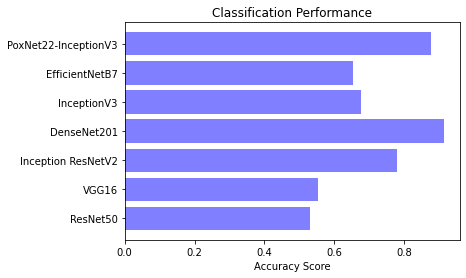

In [42]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

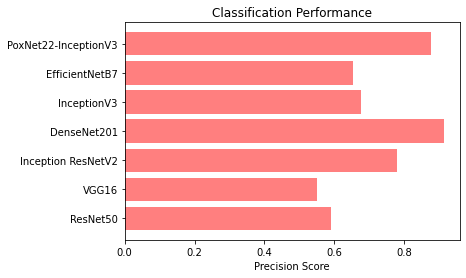

In [43]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

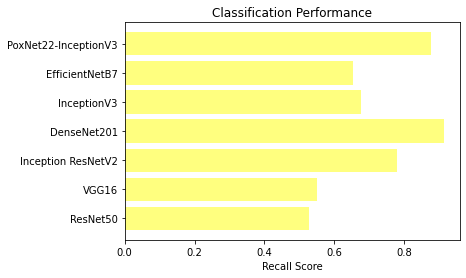

In [44]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 SCore

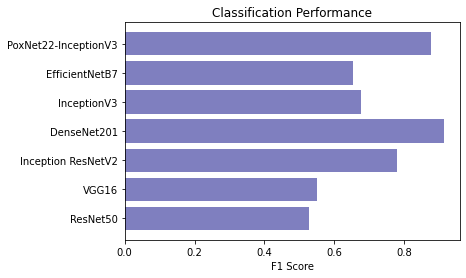

In [45]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

In [46]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()